# Imports

In [6]:
import candas as can
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from candas.test import QuantStudio
from tinydb import TinyDB

import gumbi as gmb


In [2]:

base_pth, code_pth, data_pth, rslt_pth, fig_pth = can.utils.setup_paths(make_missing=False)
plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

## Global Figure Parameters

In [221]:
width = 1.725
height = 1.75
ticklabelsize=10
labelsize=10
spotsize=8**2

In [216]:
def format_ax(ax, title='', xlabel='log$_{10}$ Transcript Copies', ylabel='FAM$-$HEX'):
    ax.set_xticks(np.arange(0, 8.5, 2))
        
    ax.set_ylabel(ylabel, fontsize=labelsize)
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_xticks(np.arange(0, 8.5, 2))
    ax.set_title(title, fontsize=labelsize+2)

    ax.tick_params(axis='both', labelsize=ticklabelsize)

    plt.subplots_adjust(
        left=0.325, 
        right=0.90, 
        top=0.875, 
        bottom=0.275
    )
    plt.setp(ax.spines.values(), linewidth=1)
    
    ax.axhline(0, lw=1, color='k', zorder=-10)
    ax.set_ylim([-1.1, 1.1])
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    
    return ax

## JG034: Direct Module

### Import Data

In [176]:
cmax = 40

file = data_pth / 'JG034 TMCC1 Gen2 Competitors - 59C v3.xlsx'
JG034 = (
    QuantStudio(file, 'JG034')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    .invert_fluorophore('HEX')
)

# for oligo in ['S036.5', 'S057.3.2', 'S057.4.2']:
#     JG071B.reactions.data['lg10 ' + oligo] = np.log10(JG071B.reactions.data[oligo])

### Plot curves for config of interest 

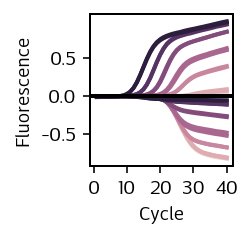

In [186]:
ax = plt.subplots(1, 1, figsize = (width, height))[1]

this = JG034.reactions.data[
    (JG034.reactions.data['Cycle'] <= cmax) &
    (JG034.reactions.data.Target.str.contains('GC55'))
]

hue = 'lg10_Copies'

g = sns.lineplot(data = this, x='Cycle', y='Fluorescence', hue=hue, 
                 palette='ch:0', units='Reaction', estimator=None, legend=False, 
                 lw=2)
ax.axhline(0, lw=2, color='k')
format_ax(ax, xlabel='Cycle', ylabel='Fluorescence')

ax.set_xticks(np.arange(0, cmax+1, 10))
ax.set_yticks([-0.5, 0, 0.5]);

### Fit GP to whole dataset

In [201]:
(JG034 
 .invert_fluorophore('HEX')
 .normalize_reactions(cmax=cmax)
 .invert_fluorophore('HEX'))
  
JG034.reactions.neaten()
JG034.extract_endpoints(cmax=cmax, name='FAM-HEX')

ds = gmb.DataSet(JG034.endpoints, outputs=['FAM-HEX'])

gp_34 = gmb.GP(ds).fit(
    continuous_dims = ['lg10_Copies'],
    # linear_dims = ['lg10_Copies'],
    categorical_dims=['Target']
)

### Plot endpoint signal for config of interest 

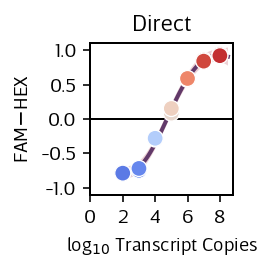

In [223]:
ax = plt.subplots(1, 1, figsize = (width, height))[1]

endpoints = JG034.endpoints

this = endpoints[
    (endpoints.Reporter=='FAM') &
    (endpoints.Target.str.contains('GC55'))
]

x_var = 'lg10_Copies'
hue = 'FAM-HEX'

g = sns.scatterplot(data = this, x=x_var, y=hue, hue=hue, hue_norm=norm, palette='coolwarm', 
                    estimator=None, s=spotsize, legend=False)

limits = gp_34.parray(**{x_var: [2.0, 8.5]})
X = gp_34.prepare_grid(limits=limits)[x_var]
y = gp_34.predict_grid(with_noise=False, categorical_levels={'Target': 'GC55 - FAM'})

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

# ax.axhline(0, lw=2, color='k')
format_ax(ax, title='Direct')
# ax.set_ylim([-1.1, 1.1])
# ax.set_yticks([-1, -0.5, 0, 0.5, 1])

plt.savefig(fig_pth / 'JG034 direct - endpoints.png', dpi=300, transparent=True);

## JG071B: Indirect Module

### Import Data

In [138]:
db_file = data_pth / 'JG071B Reaction Specifications.json'
rxn_db = TinyDB(db_file)
rxns = pd.DataFrame([rxn['oligos'] | {'Sample': rxn['name']} for rxn in rxn_db.all()])

In [139]:
cmax = 50

file = data_pth / 'JG071B Tripartite sweep GBP6.xlsx'
JG071B = (
    QuantStudio(file, 'JG071B')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    .invert_fluorophore('HEX')
)

JG071B.reactions.data = JG071B.reactions.data.merge(rxns)
for oligo in ['S036.5', 'S057.3.2', 'S057.4.2']:
    JG071B.reactions.data['lg10 ' + oligo] = np.log10(JG071B.reactions.data[oligo])

### Plot curves for config of interest 

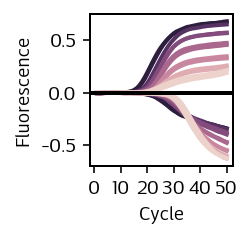

In [141]:
ax = plt.subplots(1, 1, figsize = (width, height))[1]

this = JG071B.reactions.data[
    (JG071B.reactions.data['Cycle'] <= cmax) &
    (JG071B.reactions.data['lg10 S036.5'] > 1) &
    (JG071B.reactions.data['lg10 S057.3.2'] == 6.0) &
    (JG071B.reactions.data['lg10 S057.4.2'] == 4.0)
]

hue = 'lg10 S036.5'

g = sns.lineplot(data = this, x='Cycle', y='Fluorescence', hue=hue, 
                 palette='ch:0_r', units='Reaction', estimator=None, legend=False, 
                 lw=2)
ax.axhline(0, lw=2, color='k')
format_ax(ax, xlabel='Cycle', ylabel='Fluorescence')

ax.set_xticks(np.arange(0, cmax+1, 10))
ax.set_yticks([-0.5, 0, 0.5]);

### Fit GP to whole dataset

In [168]:
(JG071B 
 .invert_fluorophore('HEX')
 .normalize_reactions(cmax=cmax)
 .invert_fluorophore('HEX'))
  
JG071B.reactions.neaten()
JG071B.extract_endpoints(cmax=cmax, name='FAM-HEX')

ds = gmb.DataSet(endpoints, outputs=['FAM-HEX'])

gp_71B = gmb.GP(ds).fit(continuous_dims = ['lg10 S036.5', 'lg10 S057.3.2', 'lg10 S057.4.2'],
                        linear_dims = ['lg10 S036.5', 'lg10 S057.3.2', 'lg10 S057.4.2'])

### Plot endpoint signal for config of interest 

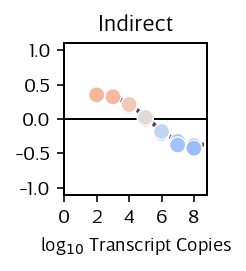

In [228]:
ax = plt.subplots(1, 1, figsize = (width, height))[1]

endpoints = JG071B.endpoints

this = endpoints[
    (endpoints.Reporter=='FAM') &
    (endpoints['lg10 S036.5'] > 1) &
    (endpoints['lg10 S057.3.2'] == 6.0) &
    (endpoints['lg10 S057.4.2'] == 4.0)
]


g = sns.scatterplot(data = this, x='lg10 S036.5', y=hue, hue=hue, hue_norm=norm, palette='coolwarm', 
                    estimator=None, s=spotsize, legend=False)

at = gp_71B.parray(**{'lg10 S057.3.2': 6.0, 'lg10 S057.4.2': 4.0})
limits = gp_71B.parray(**{'lg10 S036.5': [2.0, 8.5]})
X = gp_71B.prepare_grid(at=at, limits=limits)['lg10 S036.5']
y = gp_71B.predict_grid(with_noise=False)

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

format_ax(ax, title='Indirect', ylabel='')
# ax.set_yticks([-0.5, 0, 0.5])

plt.savefig(fig_pth / 'JG071B indirect - endpoints.png', dpi=300, transparent=True);

## JG074C: Antiparallel Redundant Module

### Import Data

In [7]:
db_file = data_pth / 'JG074C Reaction Specifications.json'
rxn_db = TinyDB(db_file)
rxns = pd.DataFrame([rxn['oligos'] | {'Sample': rxn['name']} for rxn in rxn_db.all()])

In [8]:
cmax = 50

file = data_pth / 'JG074C_L2_500_competitor_sweep.xlsx'
JG074C = (
    QuantStudio(file, 'JG074C')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    .invert_fluorophore('HEX')
)

JG074C.reactions.data = JG074C.reactions.data.merge(rxns)
for oligo in ['L2_500', 'S037.01.01b', 'S036.1b']:
    JG074C.reactions.data['lg10 ' + oligo] = np.log10(JG074C.reactions.data[oligo])

# One competitor was clearly missing from this mastermix
JG074C.reactions.wide = JG074C.reactions.wide[~(
    (JG074C.reactions.wide['lg10 S037.01.01b'] == 8.0) &
    (JG074C.reactions.wide['lg10 S036.1b'] == 2.0)
)]

### Plot curves for config of interest 

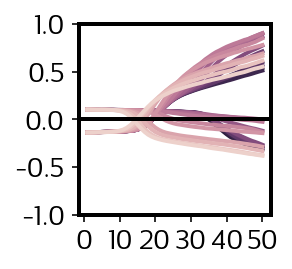

In [36]:
ax = plt.subplots(1, 1, figsize = (width, height))[1]


this = JG074C.reactions.data[
    (JG074C.reactions.data['Cycle'] <= cmax) &
#     (JG074C.reactions.data.Reporter=='FAM') &
    (JG074C.reactions.data['lg10 S037.01.01b'] == 6.0) &
    (JG074C.reactions.data['lg10 S036.1b'] == 2.0)
]

hue = 'lg10 L2_500'

g = sns.lineplot(data = this, x='Cycle', y='Fluorescence', hue=hue, palette='ch:0_r', 
                 units='Reaction', estimator=None, legend=False, lw=2)
ax.axhline(0, lw=2, color='k')
format_ax(ax)

ax.set_xticks(np.arange(0, cmax+1, 10))
ax.set_yticks([-1, -0.5, 0, 0.5, 1]);

# can.utils.savefig('JG074C parallel redundant - curves')

### Fit GP to whole dataset

In [129]:
(JG074C    
 .invert_fluorophore('HEX')
 .normalize_reactions(cmax=cmax, method='min-max')
 .invert_fluorophore('HEX'))
JG074C.reactions.neaten()
JG074C.extract_endpoints(cmax=cmax, method='bipolar', name='FAM-HEX')
endpoints = JG074C.endpoints

ds = gmb.DataSet(endpoints, outputs=['FAM-HEX'])

gp_74C = gmb.GP(ds).fit(continuous_dims = ['lg10 L2_500', 'lg10 S037.01.01b', 'lg10 S036.1b'])

### Plot endpoint signal for config of interest 

In [144]:
hue = 'FAM-HEX'
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)

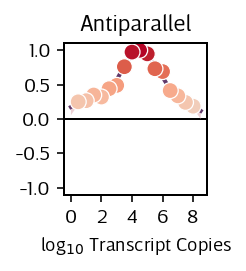

In [227]:
ax = plt.subplots(1, 1, figsize = (width, height))[1]

this = JG074C.endpoints[
    (JG074C.endpoints.Reporter=='FAM') &
#     (JG074C.endpoints['lg10 L2_500'] > 1) &
    (JG074C.endpoints['lg10 S037.01.01b'] == 6.0) &
    (JG074C.endpoints['lg10 S036.1b'] == 2.0)
]

hue = 'FAM-HEX'

g = sns.scatterplot(data = this, x='lg10 L2_500', y=hue, 
                    hue=hue, palette='coolwarm', hue_norm=norm,
                    estimator=None, s=spotsize, 
                    legend=False)


at = gp_74C.parray(**{'lg10 S037.01.01b': 6.0, 'lg10 S036.1b': 2.0})
limits = gp_74C.parray(**{'lg10 L2_500': [0, 8.5]})
X = gp_74C.prepare_grid(at=at, limits=limits)['lg10 L2_500']
y = gp_74C.predict_grid(with_noise=False)

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

format_ax(ax, title='Antiparallel', ylabel='')
# ax.set_yticks([0, 0.5, 1])

plt.savefig(fig_pth / 'JG074C antiparallel redundant - endpoints.png', dpi=300, transparent=True)

# can.utils.savefig('JG074C parallel redundant - endpoints')


## JG074D: Parallel Redundant Module

### Import Data

In [112]:
db_file = data_pth / 'JG074D Reaction Specifications.json'
rxn_db = TinyDB(db_file)
rxns = pd.DataFrame([rxn['oligos'] | {'Sample': rxn['name']} for rxn in rxn_db.all()])

In [114]:
cmax = 50

file = data_pth / 'JG074D_L2_500_like_competitor_sweep.xlsx'
JG074D = (
    QuantStudio(file, 'JG074D')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore('HEX')
)

JG074D.reactions.data = JG074D.reactions.data.merge(rxns)
for oligo in ['L2_500_like', 'S037.01.01b', 'S036.0']:
    JG074D.reactions.data['lg10 ' + oligo] = np.log10(JG074D.reactions.data[oligo])

### Plot curves for config of interest 

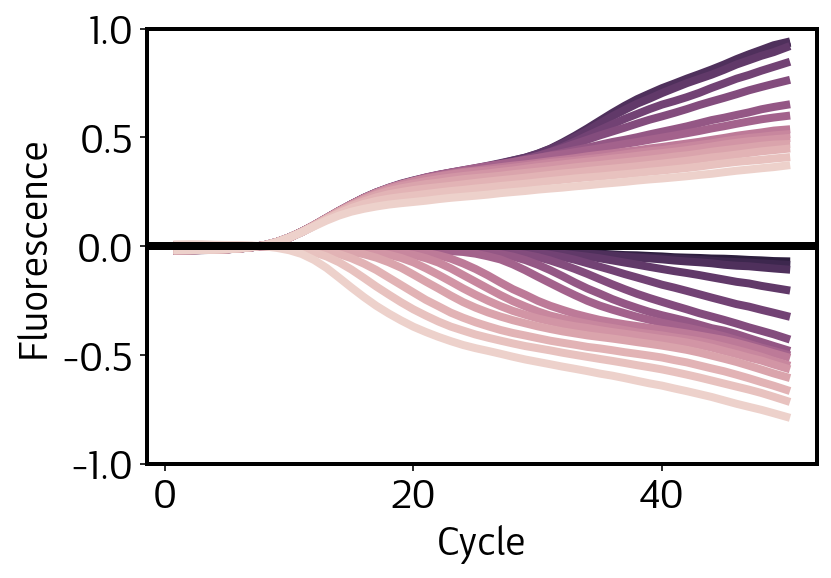

In [115]:
this = JG074D.reactions.data[
    (JG074D.reactions.data['Cycle'] <= cmax) &
#     (JG074D.reactions.data.Reporter=='FAM') &
    (JG074D.reactions.data['lg10 S037.01.01b'] == 8.0) &
    (JG074D.reactions.data['lg10 S036.0'] ==2.0)
]

hue = 'lg10 L2_500_like'

g = sns.lineplot(data = this, x='Cycle', y='Fluorescence', hue=hue, palette='ch:0_r', units='Reaction', estimator=None, legend=False, lw=4)
plt.gca().axhline(0, lw=4, color='k')
plt.ylim([-1,1]);

### Fit GP to whole dataset

In [135]:
(JG074D 
 .invert_fluorophore('HEX')
 .normalize_reactions(cmax=cmax, method='min-max')
 .invert_fluorophore('HEX'))
  
JG074D.reactions.neaten()
JG074D.extract_endpoints(cmax=cmax, method='bipolar', name='FAM-HEX')
endpoints = JG074D.endpoints

ds = gmb.DataSet(endpoints, outputs=['FAM-HEX'])

gp_74D = gmb.GP(ds).fit(continuous_dims = ['lg10 L2_500_like', 'lg10 S037.01.01b', 'lg10 S036.0'])

### Plot endpoint signal for config of interest 

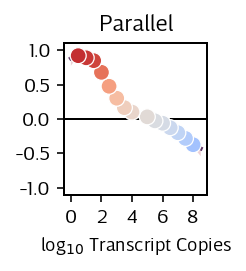

In [226]:
ax = plt.subplots(1, 1, figsize = (width, height))[1]

this = JG074D.endpoints[
    (JG074D.endpoints.Reporter=='FAM') &
#     (JG074D.endpoints['lg10 L2_500_like'] > 1) &
    (JG074D.endpoints['lg10 S037.01.01b'] == 8.0) &
    (JG074D.endpoints['lg10 S036.0'] ==2.0)
]

hue = 'FAM-HEX'

g = sns.scatterplot(data = this, x='lg10 L2_500_like', y=hue, 
                    hue=hue, hue_norm=norm, palette='coolwarm', estimator=None, 
                    s=spotsize, legend=False)

at = gp_74D.parray(**{'lg10 S037.01.01b': 8.0, 'lg10 S036.0': 2.0})
limits = gp_74D.parray(**{'lg10 L2_500_like': [0, 8.5]})
X = gp_74D.prepare_grid(at=at, limits=limits)['lg10 L2_500_like']
y = gp_74D.predict_grid(with_noise=False)

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

format_ax(ax, title='Parallel', ylabel='')
# ax.set_yticks([-0.5, 0, 0.5, 1])

plt.savefig(fig_pth / 'JG074C parallel redundant - endpoints.png', dpi=300, transparent=True)

# plt.ylim([-1.1, 1.1]);